# 🚗 Trip Anomaly Detection Analysis

## Overview
This notebook performs comprehensive anomaly detection on trip data using **rule-based methods**, **IQR-based statistical bounds**, and **detailed metric analysis**. It provides deep insights into trip behavior patterns, route efficiency, and data quality issues.

## 📋 Analysis Structure

1. **Configuration & Imports** - Set parameters and load libraries
2. **Data Loading** - Import trip data (CSV or BigQuery)
3. **Feature Engineering** - Calculate derived metrics (Haversine distance, speed, distance ratio, duration)
4. **Visualizations** - Daily trends showing trip metrics over time (6 charts)
5. **🆕 Deep Metric Analysis** - Detailed distance ratio analysis with percentiles, IQR bounds, and behavior zones
6. **Anomaly Detection** - Flag suspicious trips using rule-based + IQR-based outlier detection
7. **Comprehensive Summary** - Generate 5 detailed tables with statistics and insights
8. **Export** - Save all anomalous trips to CSV

## 🎯 Key Features

### Statistical Analysis
- **Descriptive Statistics**: 11 core metrics including count, mean, std, min, P1, Q1, Q2, Q3, P85, max, LB_IQR, UB_IQR
- **IQR-Based Bounds**: Tukey's fences (Q1 - 1.5×IQR, Q3 + 1.5×IQR) with business rule caps
- **Outlier Counts**: Both ALL data and FILTERED data perspectives for transparency

### Distance Ratio Deep Dive (Cell 14)
Comprehensive analysis of route efficiency (recorded_distance / straight_line_distance):
- **Statistical Summary**: Mean, std, quartiles, IQR
- **Percentile Distribution**: P1, P5, P10, P25, P50, P75, P85, P90, P95, P99 with interpretations
- **IQR-Based Bounds**: Lower/upper fences for anomaly detection
- **Behavior Zones Classification**:
  - Anomaly - Extremely Direct (< lower bound)
  - Direct Routes (below Q1) - efficient paths
  - Normal (Q1-Q3) - typical route efficiency
  - Detours (Q3 to upper bound) - some inefficiency
  - Anomaly - Heavy Detours (> upper bound) - major issues
- **Distribution Characteristics**: Skewness, kurtosis, coefficient of variation
- **Key Insights**: Trip counts and percentages for each zone

### Anomaly Detection Methods
1. **Rule-Based Flags**:
   - High Speed (>90.83 km/h - P86)
   - High Distance Ratio (>P95)
   - Invalid Duration (≤0 minutes)
2. **IQR-Based Outlier Detection**:
   - Counts metrics outside IQR bounds: distance, duration, ratio, speed, trip_seq, distance_diff
   - `total_outlier` (0-6): Number of metrics flagged per trip
3. **Composite Scoring**:
   - `anomaly_score` (0-3): Sum of rule-based flags
   - `anomaly_severity`: Normal / Mild anomaly / Strong anomaly

### Data Filtering Strategy
**Quality Filters Applied** (df_filtered):
- Distance > 0.5 km
- Duration > 1 minute
- Distance Ratio: 1-1000 (valid range)
- Speed: 0-100 km/h (realistic range)

**Result**: ~35,960 trips (58.6% retention) used for analysis baseline

## 🎯 Outputs

This analysis produces:
- **📊 Detailed Distance Ratio Analysis**: Full breakdown of route efficiency patterns
- **📈 5 Comprehensive Tables**: 
  - TABLE 1: Descriptive stats for 6 key metrics (with dual outlier counts)
  - TABLE 2A: Filtered metrics analysis (speed & ratio)
  - TABLE 2: Anomaly detection summary
  - TABLE 3: Flag breakdown
  - TABLE 4: User involvement
  - TABLE 5: Key findings & insights
- **📉 6 Visualizations**: Daily median trends for distance, duration, ratio, speed, trip_seq, detours
- **📋 Data Funnel**: Shows filtering progression from all data → clean data → anomalies
- **💾 1 CSV Export**: All anomalous trips with complete data

## ⚠️ Data Pre-filtering

The input data has been **pre-filtered** to exclude:
- Fake user accounts
- Users blocked by DMD
- Trips where eot ≠ 'Y'
- XANH SM service accounts

## 🚀 How to Use

1. **Run cells sequentially** from top to bottom
2. **Cell 13** creates the filtered dataset (df_filtered) used by all downstream analysis
3. **Cell 14** provides detailed distance ratio insights - review behavior zones
4. **Cell 15** performs anomaly detection with rule-based + IQR-based methods
5. **Cell 17** generates all 5 comprehensive tables
6. **Cell 18** exports anomalous trips to CSV

All analysis uses **df_filtered** (quality-screened data) as the baseline for statistical calculations and anomaly detection.

In [35]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime

# Optional: For BigQuery (uncomment if needed)
# import pydata_google_auth
# import pandas_gbq

print('Libraries imported successfully!')
print(f'  - pandas: {pd.__version__}')
print(f'  - numpy: {np.__version__}')

Libraries imported successfully!
  - pandas: 2.2.2
  - numpy: 1.26.4


## Section 2: Data Loading

Load trip data from CSV (recommended) or BigQuery.

In [36]:
# OPTION 1: Load from CSV (RECOMMENDED - Faster, no authentication needed)
csv_path = Path('trip_data.csv')

if csv_path.exists():
    df = pd.read_csv(csv_path)
    print(f'✓ Data loaded from CSV: {df.shape}')
    print(f'  - Rows: {len(df):,}')
    print(f'  - Columns: {len(df.columns)}')
else:
    raise FileNotFoundError(f'{csv_path} not found. Please ensure the data file exists or use BigQuery extraction below.')

✓ Data loaded from CSV: (61345, 34)
  - Rows: 61,345
  - Columns: 34


In [8]:
# OPTION 2: BigQuery Extraction (OPTIONAL - Uncomment to use)
# Keep this code for reference, but CSV loading is preferred for performance

import pydata_google_auth
import pandas_gbq


# Uncomment this section to extract data from BigQuery:

SCOPES = ["https://www.googleapis.com/auth/bigquery"]

credentials = pydata_google_auth.get_user_credentials(
    SCOPES,
    auth_local_webserver=True,
)

query = '''
WITH del_user AS (
  SELECT DISTINCT user_id
  FROM `datamart.bbr_fraud_monitor`
  WHERE flag_indicator = 'deleted user'
),
block_by_dmd AS (
  SELECT DISTINCT user_id
  FROM `datamart.bbr_fraud_monitor`
  WHERE flag_indicator = 'blocked by DMD'
)

SELECT b1.*
FROM `L1.bbr_fact_ps_trip_score` b1
LEFT JOIN del_user du 
  ON b1.user_id = du.user_id
LEFT JOIN block_by_dmd db 
  ON b1.user_id = db.user_id
WHERE b1.eot = 'Y'
  AND NOT EXISTS (
    SELECT 1
    FROM `L1.bbr_dim_user_xanh` u
    WHERE u.user_id = b1.user_id
  )
  AND du.user_id IS NULL     -- exclude deleted users
  AND db.user_id IS NULL;    -- exclude blocked users

'''

df = pandas_gbq.read_gbq(
    query,
    project_id="lgi-dt-dwh",
    credentials=credentials,
)

# Save to CSV for faster subsequent loads
df.to_csv('trip_data.csv', index=False)
print(f'✓ Data extracted from BigQuery and saved to trip_data.csv: {df.shape}')


print('✓ BigQuery code available (commented out). Using CSV load by default.')

Downloading: 100%|██████████|
✓ Data extracted from BigQuery and saved to trip_data.csv: (61345, 34)
✓ BigQuery code available (commented out). Using CSV load by default.


**⚠️ DATA SOURCE NOTE:**

The data used in this analysis has been **pre-filtered** to exclude:
- Users flagged as **fake accounts**
- Users **blocked by DMD** (Data Management Department)
- Trips where **eot ≠ 'Y'** (End of Trip flag)
- **XANH SM users**

This ensures we're analyzing only legitimate user trips for anomaly detection.

## Section 3: Feature Engineering

Calculate Haversine distance, distance difference, duration, and other derived features.

In [37]:
# Haversine formula to calculate straight-line GPS distance
def haversine(lat1, lon1, lat2, lon2):
    """
    Calculate great-circle distance between two points on Earth using Haversine formula.
    
    Parameters:
        lat1, lon1: Starting point coordinates (degrees)
        lat2, lon2: Ending point coordinates (degrees)
    
    Returns:
        Distance in kilometers
    """
    R = 6371  # Earth radius in km
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return R * c

# Calculate Haversine distance
df['distance_haversine'] = haversine(
    df['latitude_from'], 
    df['longitude_from'], 
    df['latitude_to'], 
    df['longitude_to']
)

print('✓ Haversine distance calculated!')
print(f'  - Mean haversine distance: {df["distance_haversine"].mean():.2f} km')
print(f'  - Max haversine distance: {df["distance_haversine"].max():.2f} km')

✓ Haversine distance calculated!
  - Mean haversine distance: 64.26 km
  - Max haversine distance: 10307.44 km


In [38]:
# Convert dates to datetime and calculate duration
df['driving_date_from'] = pd.to_datetime(df['driving_date_from'])
df['driving_date_to'] = pd.to_datetime(df['driving_date_to'])
df['trip_duration_seconds'] = (df['driving_date_to'] - df['driving_date_from']).dt.total_seconds()
df['trip_duration_minutes'] = df['trip_duration_seconds'] / 60

# Absolute detour distance (km)
df['distance_diff_km'] = df['distance'] - df['distance_haversine']

# Route efficiency ratio (>= 1 is expected)
df['distance_ratio'] = (df['distance'] / df['distance_haversine'].replace(0, np.nan))

# Average speed using driving_time (km/h)
df['avg_speed_kmh'] = df['distance'] / (df['driving_time'] / 3600).replace(0, np.nan)

print('✓ Engineered features calculated:')
print('  - trip_duration_seconds / minutes')
print('  - distance_diff_km')
print('  - distance_ratio')
print('  - avg_speed_kmh (driving_time)')

✓ Engineered features calculated:
  - trip_duration_seconds / minutes
  - distance_diff_km
  - distance_ratio
  - avg_speed_kmh (driving_time)


In [39]:
df[[
    'distance',
    'distance_diff_km',
    'trip_duration_minutes',
    'distance_ratio',
    'avg_speed_kmh',
    'trip_seq'
]].describe(percentiles=[.01, .05, .5, .95, .99])


,distance,distance_diff_km,trip_duration_minutes,distance_ratio,avg_speed_kmh,trip_seq
count,61345.000000,6.134500e+04,61345.000000,59683.000000,6.129700e+04,61345.000000
mean,78.930287,1.466730e+01,33.304023,41.260742,1.328407e+04,1.009341
std,302.555450,1.849896e+02,101.311498,591.579481,5.325609e+04,0.205622
min,0.000000,-1.030744e+04,-10078.633333,0.000000,-5.098427e-05,1.000000
1%,0.000000,-4.287926e-11,0.100000,1.000000,0.000000e+00,1.000000
5%,0.001444,9.449712e-12,0.200000,1.000000,1.038624e-01,1.000000
50%,5.764246,8.000676e-01,11.850000,1.522263,1.592709e+01,1.000000
95%,403.672993,2.859852e+01,129.723333,14.487934,8.570377e+04,1.000000
99%,1410.483642,1.557302e+02,272.292667,745.813952,2.715849e+05,1.000000
max,13489.877104,1.121875e+04,8339.516667,48333.080002,2.869562e+06,24.000000


### 📏 Metric Definitions
- `trip_duration_minutes`: Total trip time in minutes computed from `driving_date_to - driving_date_from`; negative or zero values signal timestamp/data issues.
- `distance_ratio`: Route efficiency = recorded `distance` ÷ straight-line `distance_haversine`; values close to 1 are efficient, higher values mean detours or GPS/route errors.
- `distance_diff_km`: Detour distance in km = recorded `distance` minus straight-line 
- `distance_haversine`; large positive values mean long detours, negative values imply GPS/path inconsistencies.
- `avg_speed_kmh`: Average speed in km/h using `distance` ÷ (`driving_time`/3600); extreme values usually indicate data quality problems.

In [40]:
# Basic sanity filtering (non-destructive)
df_plot = df.copy()

df_plot = df_plot[
    (df_plot['distance'] > 0) &
    (df_plot['trip_duration_minutes'] > 0) &
    (df_plot['distance_ratio'] > 1) & (df_plot['distance_ratio'] < 1000) &
    (df_plot['avg_speed_kmh'] > 0) & (df_plot['avg_speed_kmh'] <= 100) &
    (df_plot['distance_diff_km'] > 0)
]

df_plot['created_date_time'] = pd.to_datetime(df_plot['created_date_time'])

daily = df_plot.groupby(
    df_plot['created_date_time'].dt.date
).agg({
    'distance': 'median',
    'trip_duration_minutes': 'median',
    'distance_ratio': 'median',
    'avg_speed_kmh': 'median',
    'trip_seq': 'mean',
    'distance_diff_km': 'median'
}).reset_index()

daily['created_date_time'] = pd.to_datetime(daily['created_date_time'])

global_medians = {
    'distance': df_plot['distance'].median(),
    'trip_duration_minutes': df_plot['trip_duration_minutes'].median(),
    'distance_ratio': df_plot['distance_ratio'].median(),
    'avg_speed_kmh': df_plot['avg_speed_kmh'].median(),
    'trip_seq': df_plot['trip_seq'].median(),
    'distance_diff_km': df_plot['distance_diff_km'].median()
}


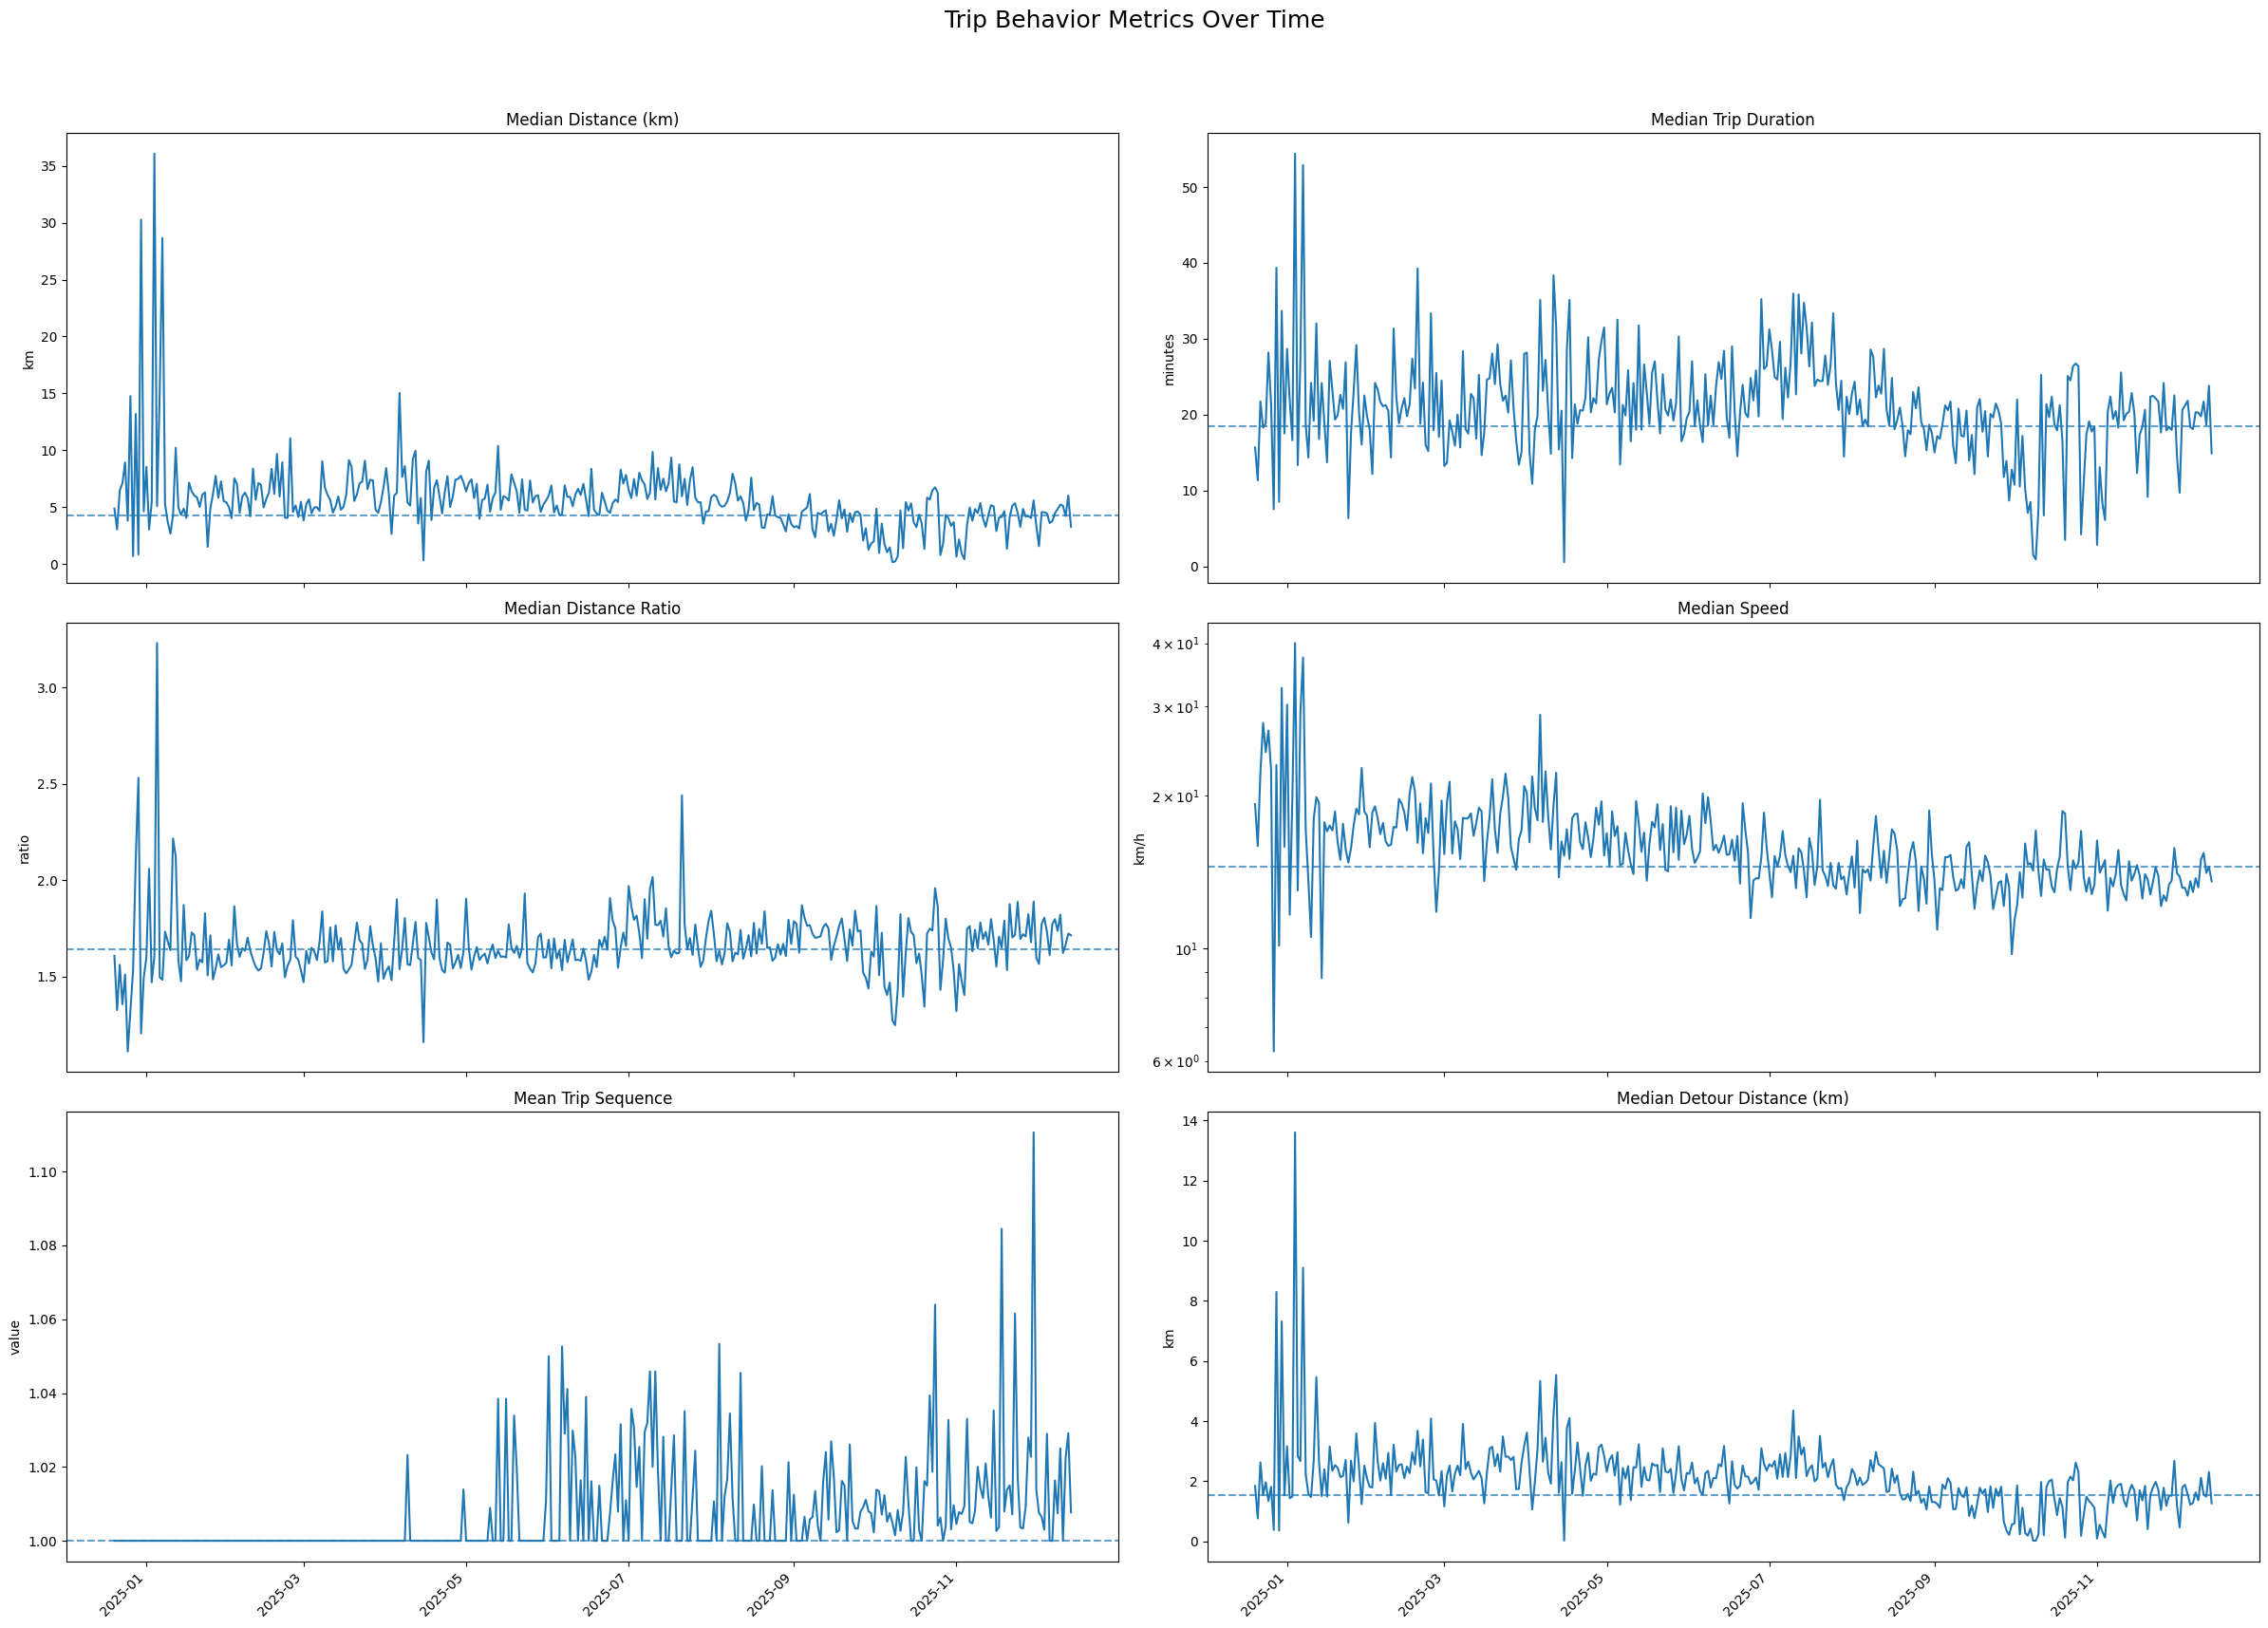

In [41]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Create a 3x2 grid
fig, axes = plt.subplots(3, 2, figsize=(24, 18), sharex=True)
fig.suptitle('Trip Behavior Metrics Over Time', fontsize=18)

# 1. Median Distance
axes[0, 0].plot(daily['created_date_time'], daily['distance'])
axes[0, 0].set_title('Median Distance (km)')
axes[0, 0].set_ylabel('km')
axes[0, 0].axhline(global_medians['distance'], linestyle='--', alpha=0.7)

# 2. Median Trip Duration
axes[0, 1].plot(daily['created_date_time'], daily['trip_duration_minutes'])
axes[0, 1].set_title('Median Trip Duration')
axes[0, 1].set_ylabel('minutes')
axes[0, 1].axhline(global_medians['trip_duration_minutes'], linestyle='--', alpha=0.7)

# 3. Median Distance Ratio
axes[1, 0].plot(daily['created_date_time'], daily['distance_ratio'])
axes[1, 0].set_title('Median Distance Ratio')
axes[1, 0].set_ylabel('ratio')
axes[1, 0].axhline(global_medians['distance_ratio'], linestyle='--', alpha=0.7)

# 4. Median Speed (log scale for outliers)
axes[1, 1].plot(daily['created_date_time'], daily['avg_speed_kmh'])
axes[1, 1].set_title('Median Speed')
axes[1, 1].set_ylabel('km/h')
axes[1, 1].axhline(global_medians['avg_speed_kmh'], linestyle='--', alpha=0.7)
axes[1, 1].set_yscale('log')

# 5. Mean Trip Sequence
axes[2, 0].plot(daily['created_date_time'], daily['trip_seq'])
axes[2, 0].set_title('Mean Trip Sequence')
axes[2, 0].set_ylabel('value')
axes[2, 0].axhline(global_medians['trip_seq'], linestyle='--', alpha=0.7)

# 6. Median Detour Distance
axes[2, 1].plot(daily['created_date_time'], daily['distance_diff_km'])
axes[2, 1].set_title('Median Detour Distance (km)')
axes[2, 1].set_ylabel('km')
axes[2, 1].axhline(global_medians['distance_diff_km'], linestyle='--', alpha=0.7)

# Rotate date labels for readability on bottom row
for ax in [axes[2, 0], axes[2, 1]]:
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_horizontalalignment('right')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [54]:
# ============================================================================
# SECTION 3: CREATE FILTERED DATASET FOR ANALYSIS
# ============================================================================
# This filtered dataset is used by:
# - Cell 14: Distance ratio deep dive analysis
# - Cell 15: Anomaly detection (rule-based + IQR-based)
# - Cell 17: Comprehensive summary tables

print("=" * 100)
print(" " * 30 + "🔍 CREATING FILTERED DATASET FOR ANALYSIS")
print("=" * 100)

# Apply quality filters to create clean dataset
df_filtered = df[
    (df['distance'] > 0.5) &
    (df['trip_duration_minutes'] > 1) &
    # (df['distance_ratio'] > 1) & (df['distance_ratio'] < 1000) &
    (df['avg_speed_kmh'] > 0) & (df['avg_speed_kmh'] <= 100)
].copy()

# Create trip_seq <= 4 filtered dataset for analysis
df_filtered_seq4 = df_filtered[pd.to_numeric(df_filtered['trip_seq'], errors='coerce') <= 4].copy()

# Create additional filter with distance_ratio <= 4.36 to remove extreme outliers
df_filtered_seq4_ratio = df_filtered_seq4[df_filtered_seq4['distance_ratio'] <= 4.36].copy()

print(f"\n📊 Filtering Results:")
print(f"  • Original Data: {len(df):,} trips")
print(f"  • Filtered Data (Quality): {len(df_filtered):,} trips ({len(df_filtered)/len(df)*100:.1f}% retained)")
print(f"  • Filtered Data (Quality + trip_seq ≤ 4): {len(df_filtered_seq4):,} trips ({len(df_filtered_seq4)/len(df)*100:.1f}% of original, {len(df_filtered_seq4)/len(df_filtered)*100:.1f}% of quality-filtered)")
print(f"  • Filtered Data (Quality + trip_seq ≤ 4 + ratio ≤ 4.36): {len(df_filtered_seq4_ratio):,} trips ({len(df_filtered_seq4_ratio)/len(df)*100:.1f}% of original, {len(df_filtered_seq4_ratio)/len(df_filtered_seq4)*100:.1f}% of seq4-filtered)")
print(f"\n📌 Quality Filters Applied:")
print(f"  • Distance > 0.5 km")
print(f"  • Duration > 1 minute")

# print(f"  • Distance Ratio: 1-1000 (valid range)")

print(f"  • Speed: 0-100 km/h (realistic range)")
print(f"  • trip_seq ≤ 4 (for df_filtered_seq4)")
print(f"  • distance_ratio ≤ 4.36 (for df_filtered_seq4_ratio - removes extreme detour outliers)")
print(f"\n✅ df_filtered, df_filtered_seq4, and df_filtered_seq4_ratio are ready for downstream analysis")

                              🔍 CREATING FILTERED DATASET FOR ANALYSIS

📊 Filtering Results:
  • Original Data: 61,345 trips
  • Filtered Data (Quality): 36,482 trips (59.5% retained)
  • Filtered Data (Quality + trip_seq ≤ 4): 36,457 trips (59.4% of original, 99.9% of quality-filtered)
  • Filtered Data (Quality + trip_seq ≤ 4 + ratio ≤ 4.36): 31,299 trips (51.0% of original, 85.9% of seq4-filtered)

📌 Quality Filters Applied:
  • Distance > 0.5 km
  • Duration > 1 minute
  • Speed: 0-100 km/h (realistic range)
  • trip_seq ≤ 4 (for df_filtered_seq4)
  • distance_ratio ≤ 4.36 (for df_filtered_seq4_ratio - removes extreme detour outliers)

✅ df_filtered, df_filtered_seq4, and df_filtered_seq4_ratio are ready for downstream analysis


In [55]:
df_filtered_seq4[[
    'distance',
    'distance_diff_km',
    'trip_duration_minutes',
    'distance_ratio',
    'avg_speed_kmh',
    'trip_seq'
]].describe(percentiles=[.01, .25, .50, .75, .85, .90, .95, .99]).T

,count,mean,std,min,1%,25%,50%,75%,85%,90%,95%,99%,max
distance,36457.0,15.586732,21.265796,0.500266,0.577780,3.395652,8.002797,19.550099,29.719773,37.977128,54.467826,99.231548,373.751287
distance_diff_km,36457.0,8.114007,14.121276,-17.236213,0.008262,1.183753,3.151056,8.637609,14.576456,20.487092,33.449527,71.568731,242.460592
trip_duration_minutes,36457.0,51.812578,74.590023,1.016667,1.433333,14.233333,29.600000,61.583333,90.666667,116.000000,168.773333,321.368000,1828.900000
distance_ratio,36457.0,65.038389,752.023530,0.209231,1.006454,1.381905,1.687908,2.569417,4.106650,6.668198,24.262094,1579.843264,48333.080002
avg_speed_kmh,36457.0,19.179086,10.943862,0.134669,1.982559,12.501829,17.055382,23.358408,27.775638,31.829103,39.000773,59.992654,99.950906
trip_seq,36457.0,1.010204,0.125720,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000


In [45]:
# ============================================================================
# TRIP_SEQ FREQUENCY ANALYSIS
# ============================================================================
print("\n" + "=" * 100)
print("🔢 TRIP_SEQ FREQUENCY ANALYSIS")
print("=" * 100)

# Prepare trip_seq series from filtered data (trip_seq <= 4)
seq = pd.to_numeric(df_filtered_seq4['trip_seq'], errors='coerce')
seq = seq.dropna().astype(int)

if len(seq) == 0:
    print("No trip_seq values available after filtering.")
else:
    total_seq = len(seq)
    unique_seq = seq.nunique()

    print(f"Total trip_seq records (filtered): {total_seq:,}")
    print(f"Unique trip_seq values: {unique_seq:,}")

    # Frequency by trip_seq value (ordered by sequence number)
    counts_by_value = seq.value_counts().sort_index()
    freq_df = counts_by_value.to_frame(name='count')
    freq_df['pct'] = (freq_df['count'] / total_seq * 100).round(2)
    freq_df.index.name = 'trip_seq'
    freq_df = freq_df.reset_index()

    print("\nFrequency by trip_seq (ordered):")
    # Show first 25 rows to avoid overly long output
    print(freq_df.head(25).to_string(index=False))
    if len(freq_df) > 25:
        print("...")
        print(freq_df.tail(10).to_string(index=False))

    # Top 15 most frequent trip_seq values
    top_counts = seq.value_counts().head(15)
    print("\nTop 15 most frequent trip_seq values:")
    print("-" * 46)
    for i, (val, cnt) in enumerate(top_counts.items(), start=1):
        pct = cnt / total_seq * 100
        print(f"{i:2d}. trip_seq {int(val):4d} | {cnt:6d} trips | {pct:5.2f}%")



🔢 TRIP_SEQ FREQUENCY ANALYSIS
Total trip_seq records (filtered): 36,457
Unique trip_seq values: 4

Frequency by trip_seq (ordered):
 trip_seq  count   pct
        1  36169 99.21
        2    224  0.61
        3     44  0.12
        4     20  0.05

Top 15 most frequent trip_seq values:
----------------------------------------------
 1. trip_seq    1 |  36169 trips | 99.21%
 2. trip_seq    2 |    224 trips |  0.61%
 3. trip_seq    3 |     44 trips |  0.12%
 4. trip_seq    4 |     20 trips |  0.05%


In [46]:
# ============================================================================
# SECTION 3.5: DETAILED DISTANCE RATIO ANALYSIS
# ============================================================================
# Distance Ratio = recorded_distance / straight_line_distance (Haversine)
# This metric shows route efficiency / detour severity
# Ratio = 1 means direct route (efficient)
# Ratio > 1 means detours or GPS errors (less efficient)
# Higher ratio = more detours / longer route

print("=" * 100)
print(" " * 25 + "📊 DETAILED DISTANCE RATIO ANALYSIS")
print("=" * 100)

# Use df_filtered_seq4 created in previous cell
distance_ratio_filtered = df_filtered_seq4['distance_ratio'].dropna()

print(f"\n📌 Dataset Information:")
print(f"  • Original Data: {len(df):,} trips")
print(f"  • Analysis Data: df_filtered_seq4 ({len(df_filtered_seq4):,} trips, trip_seq ≤ 4)")

# ============================================================================
# STATISTICAL SUMMARY
# ============================================================================
print("\n" + "=" * 100)
print("📈 STATISTICAL SUMMARY - DISTANCE RATIO")
print("=" * 100)

stats_summary = {
    'Metric': ['Count', 'Mean', 'Std Dev', 'Min', 'Q1 (25%)', 'Q2 (Median)', 'Q3 (75%)', 'Max', 'IQR (Q3-Q1)'],
    'Value': [
        f"{len(distance_ratio_filtered):,}",
        f"{distance_ratio_filtered.mean():.4f}",
        f"{distance_ratio_filtered.std():.4f}",
        f"{distance_ratio_filtered.min():.4f}",
        f"{distance_ratio_filtered.quantile(0.25):.4f}",
        f"{distance_ratio_filtered.quantile(0.50):.4f}",
        f"{distance_ratio_filtered.quantile(0.75):.4f}",
        f"{distance_ratio_filtered.max():.4f}",
        f"{distance_ratio_filtered.quantile(0.75) - distance_ratio_filtered.quantile(0.25):.4f}"
    ]
}

stats_df = pd.DataFrame(stats_summary)
print("\n" + stats_df.to_string(index=False))

# ============================================================================
# PERCENTILE BREAKDOWN
# ============================================================================
print("\n" + "=" * 100)
print("📊 PERCENTILE DISTRIBUTION")
print("=" * 100)

percentiles = [1, 5, 10, 25, 50, 75, 85, 90, 95, 99]
percentile_values = {p: distance_ratio_filtered.quantile(p/100) for p in percentiles}

percentile_summary = {
    'Percentile': [f"P{p}" for p in percentiles],
    'Distance Ratio': [f"{v:.4f}" for v in percentile_values.values()],
    'Interpretation': [
        'Extreme direct routes',
        'Very direct routes',
        'Direct routes',
        'Q1 (Lower quartile)',
        'Q2 (Median) - Normal behavior',
        'Q3 (Upper quartile)',
        'More detours',
        'Significant detours',
        'Heavy detours',
        'Extreme outliers'
    ]
}

percentile_df = pd.DataFrame(percentile_summary)
print("\n" + percentile_df.to_string(index=False))

# ---- Tail spike check between P95 and P99 ----
import numpy as np
fine_ps = [95, 96, 97, 98, 99]
fine_vals = {p: float(distance_ratio_filtered.quantile(p/100)) for p in fine_ps}
ordered_vals = [fine_vals[p] for p in fine_ps]
deltas = [ordered_vals[i] - ordered_vals[i-1] for i in range(1, len(ordered_vals))]

idx_max = int(np.argmax(deltas))
p_low = fine_ps[idx_max]
p_high = fine_ps[idx_max + 1]
v_low = ordered_vals[idx_max]
v_high = ordered_vals[idx_max + 1]

print("\n" + "-" * 100)
print("TAIL SPIKE CHECK (P95–P99)")
print("-" * 100)
print("Percentiles:")
for p in fine_ps:
    print(f"  P{p:>2}: {fine_vals[p]:.4f}")
print("\nStep changes:")
for i in range(1, len(fine_ps)):
    print(f"  P{fine_ps[i-1]}→P{fine_ps[i]}: +{deltas[i-1]:.4f}")
print(f"\nLargest jump between P{p_low} and P{p_high}: +{(v_high - v_low):.4f}")
print(f"➡️ Spike likely begins around P{p_low}–P{p_high} (≈ {v_low:.4f}–{v_high:.4f})")

# ============================================================================
# IQR-BASED BOUNDS (TUKEY'S FENCES)
# ============================================================================
print("\n" + "=" * 100)
print("🔍 IQR-BASED BOUNDS (Tukey's Fences for Anomaly Detection)")
print("=" * 100)

q1 = distance_ratio_filtered.quantile(0.25)
q3 = distance_ratio_filtered.quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Cap at practical limits
lower_bound_capped = max(lower_bound, 1.0)  # Minimum reasonable distance ratio (direct route)
upper_bound_capped = upper_bound  # No hard cap

bounds_summary = {
    'Bound': ['Q1 (25%)', 'Q3 (75%)', 'IQR (Q3-Q1)', 'Lower Bound (Q1 - 1.5×IQR)', 'Upper Bound (Q3 + 1.5×IQR)', 'Lower Bound (Capped at 1.0)', 'Upper Bound (Final)'],
    'Value': [
        f"{q1:.4f}",
        f"{q3:.4f}",
        f"{iqr:.4f}",
        f"{lower_bound:.4f}",
        f"{upper_bound:.4f}",
        f"{lower_bound_capped:.4f}",
        f"{upper_bound_capped:.4f}"
    ],
    'Interpretation': [
        'Lower 25% of data',
        'Upper 25% of data',
        'Spread of middle 50%',
        'Lower fence (before capping)',
        'Upper fence - heavy detour anomalies',
        'Lower fence - extremely direct routes',
        'Upper fence - extremely heavy detours'
    ]
}

bounds_df = pd.DataFrame(bounds_summary)
print("\n" + bounds_df.to_string(index=False))

# ============================================================================
# NORMAL BEHAVIOR CLASSIFICATION
# ============================================================================
print("\n" + "=" * 100)
print("🎯 NORMAL BEHAVIOR ZONES")
print("=" * 100)

normal_trips = (distance_ratio_filtered >= q1) & (distance_ratio_filtered <= q3)
direct_trips = distance_ratio_filtered < q1
detour_trips = (distance_ratio_filtered > q3) & (distance_ratio_filtered <= upper_bound_capped)
anomaly_direct = distance_ratio_filtered < lower_bound_capped
anomaly_detour = distance_ratio_filtered > upper_bound_capped

behavior_zones = {
    'Behavior Zone': [
        'Anomaly - Extremely Direct',
        'Direct (Below Normal)',
        'Normal (Q1-Q3)',
        'Detours (Above Normal)',
        'Anomaly - Extremely Heavy Detours',
        'TOTAL'
    ],
    'Distance Ratio Range': [
        f'< {lower_bound_capped:.4f}',
        f'{lower_bound_capped:.4f} to {q1:.4f}',
        f'{q1:.4f} to {q3:.4f}',
        f'{q3:.4f} to {upper_bound_capped:.4f}',
        f'> {upper_bound_capped:.4f}',
        '—'
    ],
    'Trip Count': [
        anomaly_direct.sum(),
        direct_trips.sum(),
        normal_trips.sum(),
        detour_trips.sum(),
        anomaly_detour.sum(),
        len(distance_ratio_filtered)
    ],
    'Percentage': [
        f"{anomaly_direct.sum()/len(distance_ratio_filtered)*100:.2f}%",
        f"{direct_trips.sum()/len(distance_ratio_filtered)*100:.2f}%",
        f"{normal_trips.sum()/len(distance_ratio_filtered)*100:.2f}%",
        f"{detour_trips.sum()/len(distance_ratio_filtered)*100:.2f}%",
        f"{anomaly_detour.sum()/len(distance_ratio_filtered)*100:.2f}%",
        "100.00%"
    ],
    'Interpretation': [
        '⚠️ Extremely direct - data quality issue or GPS error',
        '✈️ Direct routes - efficient paths',
        '✓ Normal behavior - typical trip efficiency',
        '🛣️ Detours - some route inefficiency',
        '🚨 Heavy detours - major anomaly',
        '—'
    ]
}

behavior_df = pd.DataFrame(behavior_zones)
print("\n" + behavior_df.to_string(index=False))

# ============================================================================
# DISTRIBUTION ANALYSIS
# ============================================================================
print("\n" + "=" * 100)
print("📉 DISTRIBUTION CHARACTERISTICS")
print("=" * 100)

skewness = distance_ratio_filtered.skew()
kurtosis = distance_ratio_filtered.kurtosis()

distribution_info = {
    'Property': [
        'Skewness',
        'Kurtosis',
        'Coefficient of Variation',
        'Range',
        'Mean > Median?',
        'Data Pattern'
    ],
    'Value': [
        f"{skewness:.4f}",
        f"{kurtosis:.4f}",
        f"{(distance_ratio_filtered.std() / distance_ratio_filtered.mean()):.4f}",
        f"{distance_ratio_filtered.max() - distance_ratio_filtered.min():.4f}",
        "Yes" if distance_ratio_filtered.mean() > distance_ratio_filtered.median() else "No",
        'Right-skewed (longer tail)' if skewness > 0 else 'Left-skewed' if skewness < 0 else 'Symmetric'
    ],
    'Interpretation': [
        'Positive = longer tail of heavy detours',
        'High = extreme detour outliers present',
        'Higher = more variability in route efficiency',
        'Spread of data',
        'Indicates presence of extreme detours',
        'Distribution shape'
    ]
}

dist_df = pd.DataFrame(distribution_info)
print("\n" + dist_df.to_string(index=False))

# ============================================================================
# KEY INSIGHTS
# ============================================================================
print("\n" + "=" * 100)
print("💡 KEY INSIGHTS & INTERPRETATION")
print("=" * 100)

print(f"""
Normal Behavior (Q1-Q3):
  • Distance ratio between {q1:.4f} and {q3:.4f}
  • {normal_trips.sum():,} trips ({normal_trips.sum()/len(distance_ratio_filtered)*100:.1f}%)
  • Represents typical route efficiency in the system
  
Direct Routes (Below Normal):
  • Distance ratio < {q1:.4f}
  • {direct_trips.sum():,} trips ({direct_trips.sum()/len(distance_ratio_filtered)*100:.1f}%)
  • More efficient paths, direct highways, or good routing
  
Detours (Above Normal):
  • Distance ratio {q3:.4f} to {upper_bound_capped:.4f}
  • {detour_trips.sum():,} trips ({detour_trips.sum()/len(distance_ratio_filtered)*100:.1f}%)
  • Some route inefficiency, GPS errors, or traffic detours
  
⚠️ Anomalies:
  • Extremely Direct: {anomaly_direct.sum():,} trips ({anomaly_direct.sum()/len(distance_ratio_filtered)*100:.2f}%) - data quality issues
  • Extremely Heavy Detours: {anomaly_detour.sum():,} trips ({anomaly_detour.sum()/len(distance_ratio_filtered)*100:.2f}%) - major anomalies

Distribution Pattern:
  • Skewness {skewness:.4f}: {'Right-skewed (tail toward heavier detours)' if skewness > 0 else 'Left-skewed'}
  • Mean ({distance_ratio_filtered.mean():.4f}) vs Median ({distance_ratio_filtered.median():.4f})
  • Indicates distribution is influenced by {'heavy detour outliers' if skewness > 0 else 'direct route outliers'}
""")

print("=" * 100)


                         📊 DETAILED DISTANCE RATIO ANALYSIS

📌 Dataset Information:
  • Original Data: 61,345 trips
  • Analysis Data: df_filtered_seq4 (36,457 trips, trip_seq ≤ 4)

📈 STATISTICAL SUMMARY - DISTANCE RATIO

     Metric      Value
      Count     36,457
       Mean    65.0384
    Std Dev   752.0235
        Min     0.2092
   Q1 (25%)     1.3819
Q2 (Median)     1.6879
   Q3 (75%)     2.5694
        Max 48333.0800
IQR (Q3-Q1)     1.1875

📊 PERCENTILE DISTRIBUTION

Percentile Distance Ratio                Interpretation
        P1         1.0065         Extreme direct routes
        P5         1.0943            Very direct routes
       P10         1.1947                 Direct routes
       P25         1.3819           Q1 (Lower quartile)
       P50         1.6879 Q2 (Median) - Normal behavior
       P75         2.5694           Q3 (Upper quartile)
       P85         4.1066                  More detours
       P90         6.6682           Significant detours
       P95      

In [47]:
# ANOMALY DETECTION: RULE-BASED + IQR-BASED OUTLIER DETECTION
# ============================================================================

# Note: df_filtered_seq4 already created (quality-screened data with trip_seq <= 4)

# Create anomaly flags on filtered data (fill NaN with False)
df_filtered_seq4['flag_speed_high'] = (df_filtered_seq4['avg_speed_kmh'] > 100).fillna(False)
df_filtered_seq4['flag_ratio_high'] = (df_filtered_seq4['distance_ratio'] > 1000).fillna(False)
df_filtered_seq4['flag_duration_invalid'] = (df_filtered_seq4['trip_duration_minutes'] <= 0).fillna(False)

# Calculate composite anomaly score (0-3) on filtered data
df_filtered_seq4['anomaly_score'] = (
    df_filtered_seq4['flag_speed_high'].astype(int) +
    df_filtered_seq4['flag_ratio_high'].astype(int) +
    df_filtered_seq4['flag_duration_invalid'].astype(int)
)

# ============================================================================
# IQR-BASED OUTLIER DETECTION (using LB_IQR / UB_IQR bounds) on filtered data
# ============================================================================

def iqr_bounds_calc(s, min_valid=None, max_valid=None, k=1.5):
    """Helper function to calculate IQR-based bounds"""
    s = s.dropna()
    if len(s) == 0:
        return np.nan, np.nan
    q1 = s.quantile(0.25)
    q3 = s.quantile(0.75)
    iqr = q3 - q1
    lb = q1 - k * iqr
    ub = q3 + k * iqr
    if min_valid is not None:
        lb = max(lb, min_valid)
    if max_valid is not None:
        ub = min(ub, max_valid)
    return lb, ub

# Define IQR bounds for each metric (filtered data with trip_seq <= 4)
iqr_bounds_dict = {}
metrics_for_iqr = [
    'distance', 'trip_duration_minutes', 'distance_ratio',
    'avg_speed_kmh', 'trip_seq', 'distance_diff_km'
]

for m in metrics_for_iqr:
    min_valid = 0 if m in ['distance', 'trip_duration_minutes', 'avg_speed_kmh', 'distance_diff_km'] else None
    max_valid = 100 if m == 'avg_speed_kmh' else None
    lb, ub = iqr_bounds_calc(df_filtered_seq4[m], min_valid=min_valid, max_valid=max_valid, k=1.5)
    iqr_bounds_dict[m] = {'LB': lb, 'UB': ub}

# Count how many metrics fall outside their IQR bounds (filtered data)
def count_iqr_outliers(row, bounds_dict, metrics_list):
    """Count how many metrics have values outside their IQR bounds"""
    count = 0
    for m in metrics_list:
        if pd.notna(row[m]) and m in bounds_dict:
            lb, ub = bounds_dict[m]['LB'], bounds_dict[m]['UB']
            if pd.notna(lb) and pd.notna(ub):
                if row[m] < lb or row[m] > ub:
                    count += 1
    return count

df_filtered_seq4['total_outlier'] = df_filtered_seq4.apply(
    lambda row: count_iqr_outliers(row, iqr_bounds_dict, metrics_for_iqr),
    axis=1
)

# Classify severity on filtered data
def anomaly_severity(score):
    if score == 0:
        return 'Normal'
    elif score == 1:
        return 'Mild anomaly'
    else:
        return 'Strong anomaly'

df_filtered_seq4['anomaly_severity'] = df_filtered_seq4['anomaly_score'].apply(anomaly_severity)

# Attach anomaly columns back to df for reporting (left join on trip_id)
cols_to_merge = [
    'trip_id',
    'anomaly_score',
    'anomaly_severity',
    'flag_speed_high',
    'flag_ratio_high',
    'flag_duration_invalid',
    'total_outlier'
]
df = df.merge(df_filtered_seq4[cols_to_merge], on='trip_id', how='left', suffixes=('', '_filtered'))

# Summary statistics (filtered focus with trip_seq <= 4)
print("🚨 ANOMALY DETECTION SUMMARY")
print("=" * 50)
print(f"\nTotal trips analyzed: {len(df):,} (all data), {len(df_filtered_seq4):,} (filtered/quality-screened with trip_seq ≤ 4)")
print(f"\n📊 DATA FUNNEL (Using Filtered Data with trip_seq ≤ 4):")
print(f"  ├─ Filtered Data:  {len(df_filtered_seq4):,} trips (100.0% of clean data with trip_seq ≤ 4)")
print(f"  └─ Anomalies:      {(df_filtered_seq4['anomaly_score'] > 0).sum():,} trips ({(df_filtered_seq4['anomaly_score'] > 0).sum()/len(df_filtered_seq4)*100:.1f}% of filtered)")

print(f"\nAnomaly Score Distribution (Rule-Based):")
print(df_filtered_seq4['anomaly_score'].value_counts(normalize=True).sort_index().apply(lambda x: f"{x*100:.1f}%"))
print(f"\nSeverity Breakdown:")
print(df_filtered_seq4['anomaly_severity'].value_counts())
print(f"\nTrips with ANY anomaly flag: {(df_filtered_seq4['anomaly_score'] > 0).sum():,} ({(df_filtered_seq4['anomaly_score'] > 0).sum()/len(df_filtered_seq4)*100:.1f}%)")
print(f"\n📊 IQR-Based Outlier Count Distribution (total_outlier):")
print(df_filtered_seq4['total_outlier'].value_counts(normalize=True).sort_index().apply(lambda x: f"{x*100:.1f}%"))


🚨 ANOMALY DETECTION SUMMARY

Total trips analyzed: 61,345 (all data), 36,457 (filtered/quality-screened with trip_seq ≤ 4)

📊 DATA FUNNEL (Using Filtered Data with trip_seq ≤ 4):
  ├─ Filtered Data:  36,457 trips (100.0% of clean data with trip_seq ≤ 4)
  └─ Anomalies:      502 trips (1.4% of filtered)

Anomaly Score Distribution (Rule-Based):
anomaly_score
0    98.6%
1     1.4%
Name: proportion, dtype: object

Severity Breakdown:
anomaly_severity
Normal          35955
Mild anomaly      502
Name: count, dtype: int64

Trips with ANY anomaly flag: 502 (1.4%)

📊 IQR-Based Outlier Count Distribution (total_outlier):
total_outlier
0    75.3%
1    13.5%
2     4.8%
3     3.5%
4     2.4%
5     0.5%
Name: proportion, dtype: object


In [ ]:
# =============================================================================
# COMPREHENSIVE ANALYSIS SUMMARY
# =============================================================================

# Note: Uses df_filtered_seq4 from Cell 14 (quality-screened with trip_seq <= 4)
# Create validation subsets for TABLE 5 findings only
valid_speed = df_filtered_seq4  
valid_ratio = df_filtered_seq4  
valid_distance = df_filtered_seq4[df_filtered_seq4['distance'] > 0.5]
valid_duration = df_filtered_seq4[df_filtered_seq4['trip_duration_minutes'] > 1]

print("=" * 100)
print(" " * 35 + "📊 TRIP ANOMALY ANALYSIS SUMMARY")
print("=" * 100)

# Display DATA FUNNEL showing filtering progression
print("\n" + "=" * 100)
print("📊 DATA FUNNEL: Analysis Scope (Filtered Data with trip_seq ≤ 4)")
print("=" * 100)
total_data = len(df)
filtered_data_count = len(df_filtered_seq4)
anomalies_in_filtered = (df_filtered_seq4['anomaly_score'] > 0).sum()

print(f"\n  📋 Starting Point: {total_data:,} total trips")
print(f"  ├─ After Quality Filters: {len(df_filtered):,} trips ({len(df_filtered)/total_data*100:.1f}% retained)")
print(f"  ├─ After Quality + trip_seq ≤ 4 Filters: {filtered_data_count:,} trips ({filtered_data_count/total_data*100:.1f}% of original, {filtered_data_count/len(df_filtered)*100:.1f}% of quality-filtered)")
print(f"  │    └─ Exclusions from filtering:")
print(f"  │       • distance ≤ 0.5: {len(df_filtered_seq4[df_filtered_seq4['distance'] <= 0.5]):,} trips")
print(f"  │       • duration ≤ 1: {len(df_filtered_seq4[df_filtered_seq4['trip_duration_minutes'] <= 1]):,} trips")
print(f"  │       • ratio ≤ 1 or ≥ 1000: {len(df_filtered_seq4[(df_filtered_seq4['distance_ratio'] <= 1) | (df_filtered_seq4['distance_ratio'] >= 1000)]):,} trips")
print(f"  │       • speed ≤ 0 or > 100: {len(df_filtered_seq4[(df_filtered_seq4['avg_speed_kmh'] <= 0) | (df_filtered_seq4['avg_speed_kmh'] > 100)]):,} trips")
print(f"  │")
print(f"  ├─ Clean Data (Base for Analysis): {filtered_data_count:,} trips (100.0%)")
print(f"  └─ Anomalies Detected: {anomalies_in_filtered:,} trips ({anomalies_in_filtered/filtered_data_count*100:.1f}% of clean data)")

# =============================================================================
# TABLE 1: DESCRIPTIVE STATISTICS FOR KEY METRICS
# =============================================================================
print("\n" + "=" * 100)
print("TABLE 1: DESCRIPTIVE STATISTICS FOR KEY TRIP METRICS (Based on Filtered Data with trip_seq ≤ 4)")
print("=" * 100)
print(f"Note: Statistics calculated on {filtered_data_count:,} filtered trips (quality-screened data with trip_seq ≤ 4)")
print("      Outlier counts are shown in a separate table below\n")

# Select key metrics
metrics = [
    'distance', 
    'trip_duration_minutes', 
    'distance_ratio', 
    'avg_speed_kmh', 
    'trip_seq',
    'distance_diff_km'
]

# Include 85% and 90% percentiles for better upper-tail visibility
desc_stats = df_filtered_seq4[metrics].describe(percentiles=[.01, .25, .50, .75, .85, .90, .95, .99]).T
desc_stats['mean'] = df_filtered_seq4[metrics].mean()
desc_stats['std'] = df_filtered_seq4[metrics].std()

# Rename selected percentile columns to requested labels
desc_stats = desc_stats.rename(columns={
    '1%': 'P1',
    '25%': 'Q1',
    '50%': 'Q2',
    '75%': 'Q3',
    '85%': 'P85'
})

# Reorder columns for better readability (use renamed labels)
desc_stats = desc_stats[['count', 'mean', 'std', 'min', 'P1', 'Q1', 'Q2', 'Q3', 'P85', 'max']]

# Format for display
desc_stats_display = desc_stats.copy()
desc_stats_display = desc_stats_display.round(2)

# --- IQR-based bounds (behavioral fences) ---
# Note: Reusing iqr_bounds_calc from Cell 14 (Anomaly Detection) with simpler name
iqr_bounds = iqr_bounds_calc  # Reference to function already defined in Cell 14

bounds = {}
for m in metrics:
    min_valid = 0 if m in ['distance', 'trip_duration_minutes', 'avg_speed_kmh', 'distance_diff_km'] else None
    max_valid = 100 if m == 'avg_speed_kmh' else None
    lb, ub = iqr_bounds(df_filtered_seq4[m], min_valid=min_valid, max_valid=max_valid, k=1.5)
    bounds[m] = {'LB_IQR': round(lb, 2) if pd.notna(lb) else lb, 'UB_IQR': round(ub, 2) if pd.notna(ub) else ub}

bounds_df = pd.DataFrame(bounds).T
# Append IQR bounds to the display table (side-by-side with percentiles)
desc_stats_display[['LB_IQR', 'UB_IQR']] = bounds_df[['LB_IQR', 'UB_IQR']]

# --- Count how many trips are outliers for each metric ---
# Note: Use df_filtered (quality-screened only) for outlier comparison, not df_filtered_seq4
# Outlier_Count_All: Count from ALL data (df)
outlier_counts_all = {}
for m in metrics:
    lb = bounds_df.loc[m, 'LB_IQR']
    ub = bounds_df.loc[m, 'UB_IQR']
    if pd.notna(lb) and pd.notna(ub):
        outlier_count = len(df[(df[m] < lb) | (df[m] > ub)])
        outlier_pct = (outlier_count / len(df)) * 100
        outlier_counts_all[m] = f"{outlier_count:,} ({outlier_pct:.2f}%)"
    else:
        outlier_counts_all[m] = "N/A"

# Outlier_Count_Filtered: Count from quality-filtered data (df_filtered, all trip_seq)
outlier_counts_filtered = {}
for m in metrics:
    lb = bounds_df.loc[m, 'LB_IQR']
    ub = bounds_df.loc[m, 'UB_IQR']
    if pd.notna(lb) and pd.notna(ub):
        outlier_count = len(df_filtered[(df_filtered[m] < lb) | (df_filtered[m] > ub)])
        outlier_pct = (outlier_count / len(df_filtered)) * 100
        outlier_counts_filtered[m] = f"{outlier_count:,} ({outlier_pct:.2f}%)"
    else:
        outlier_counts_filtered[m] = "N/A"

# Outlier_Count_Seq4: Count from quality-filtered data with trip_seq <= 4 (df_filtered_seq4)
outlier_counts_seq4 = {}
for m in metrics:
    lb = bounds_df.loc[m, 'LB_IQR']
    ub = bounds_df.loc[m, 'UB_IQR']
    if pd.notna(lb) and pd.notna(ub):
        outlier_count = len(df_filtered_seq4[(df_filtered_seq4[m] < lb) | (df_filtered_seq4[m] > ub)])
        outlier_pct = (outlier_count / len(df_filtered_seq4)) * 100
        outlier_counts_seq4[m] = f"{outlier_count:,} ({outlier_pct:.2f}%)"
    else:
        outlier_counts_seq4[m] = "N/A"

# Outlier_Count_Seq4_Ratio: Count from quality-filtered data with trip_seq <= 4 AND distance_ratio <= 4.36 (df_filtered_seq4_ratio)
outlier_counts_seq4_ratio = {}
for m in metrics:
    lb = bounds_df.loc[m, 'LB_IQR']
    ub = bounds_df.loc[m, 'UB_IQR']
    if pd.notna(lb) and pd.notna(ub):
        outlier_count = len(df_filtered_seq4_ratio[(df_filtered_seq4_ratio[m] < lb) | (df_filtered_seq4_ratio[m] > ub)])
        outlier_pct = (outlier_count / len(df_filtered_seq4_ratio)) * 100
        outlier_counts_seq4_ratio[m] = f"{outlier_count:,} ({outlier_pct:.2f}%)"
    else:
        outlier_counts_seq4_ratio[m] = "N/A"

# Build an outlier-only table to keep separation from main stats
outlier_table = pd.DataFrame({
    'Outlier_Count_All': pd.Series(outlier_counts_all),
    'Outlier_Count_Filtered': pd.Series(outlier_counts_filtered),
    'Outlier_Count_Seq4': pd.Series(outlier_counts_seq4),
    'Outlier_Count_Seq4_Ratio': pd.Series(outlier_counts_seq4_ratio)
})

print("\n" + desc_stats_display.to_string())
print("\n" + "-" * 100)
print("Outlier counts (IQR fences) by scope:")
print(outlier_table.to_string())
print("\nℹ️ Outlier_Count_All uses the full dataset (df).\n   Outlier_Count_Filtered uses the quality-screened df_filtered (distance>0.5 km, duration>1 min, 0<speed<=100 km/h, all trip_seq).\n   Outlier_Count_Seq4 uses the quality-screened df_filtered_seq4 (same filters + trip_seq ≤ 4).\n   Outlier_Count_Seq4_Ratio uses df_filtered_seq4_ratio (same filters + trip_seq ≤ 4 + distance_ratio ≤ 4.36).\n   Note: IQR bounds are calculated from df_filtered_seq4 (trip_seq ≤ 4) for tighter thresholds.")

print("\n📌 Key Observations:")
print(f"  • Distance: Mean {desc_stats.loc['distance', 'mean']:.1f} km, Max {desc_stats.loc['distance', 'max']:.1f} km")
print(f"  • Duration: Mean {desc_stats.loc['trip_duration_minutes', 'mean']:.1f} min, some negative values (data issue)")
print(f"  • Distance Ratio: Mean {desc_stats.loc['distance_ratio', 'mean']:.2f}, Max {desc_stats.loc['distance_ratio', 'max']:.1f} (impossible)")
print(f"  • Speed: Mean {desc_stats.loc['avg_speed_kmh', 'mean']:.1f} km/h, extreme outliers detected")

# =============================================================================
# TABLE 2A: FILTERED METRICS ANALYSIS (Speed & Distance Ratio)
# =============================================================================
print("\n\n" + "=" * 100)
print("TABLE 2A: FILTERED METRICS ANALYSIS (0 < speed ≤ 100 km/h)")
print("=" * 100)
print(f"Note: Statistics calculated on filtered data; comparisons show all data vs filtered data impact\n")

# Filter realistic speeds and distance ratios (same boundary as df_filtered_seq4)
filtered_speeds = df_filtered_seq4['avg_speed_kmh']
filtered_ratios = df_filtered_seq4['distance_ratio']

print(f"\n📊 Coverage:")
print(f"   Speed (0 < speed ≤ 100): {len(filtered_speeds):,} trips ({len(filtered_speeds)/len(df)*100:.1f}%) | Excluded: {len(df)-len(filtered_speeds):,} ({(len(df)-len(filtered_speeds))/len(df)*100:.1f}%)")
print(f"   Ratio (all values): {len(filtered_ratios):,} trips ({len(filtered_ratios)/len(df)*100:.1f}%) | Excluded: {len(df)-len(filtered_ratios):,} ({(len(df)-len(filtered_ratios))/len(df)*100:.1f}%)")

# Create DataFrame with both metrics
filtered_data = pd.DataFrame({
    'avg_speed_kmh': filtered_speeds,
    'distance_ratio': filtered_ratios
})

# Calculate statistics with same format as TABLE 1
filtered_stats = filtered_data.describe(percentiles=[.01, .25, .50, .75, .85, .90, .95, .99]).T
filtered_stats['mean'] = filtered_data.mean()
filtered_stats['std'] = filtered_data.std()

# Rename percentile columns
filtered_stats = filtered_stats.rename(columns={
    '1%': 'P1',
    '25%': 'Q1',
    '50%': 'Q2',
    '75%': 'Q3',
    '85%': 'P85'
})

# Reorder columns to match TABLE 1 format (use renamed labels)
filtered_stats = filtered_stats[['count', 'mean', 'std', 'min', 'P1', 'Q1', 'Q2', 'Q3', 'P85', 'max']]

# Format for display
filtered_stats_display = filtered_stats.copy()
filtered_stats_display = filtered_stats_display.round(2)

# IQR bounds for filtered metrics (with business caps)
bounds2 = {}
for m in ['avg_speed_kmh', 'distance_ratio']:
    min_valid = 0 if m == 'avg_speed_kmh' else 1
    max_valid = 100 if m == 'avg_speed_kmh' else 1000
    lb, ub = iqr_bounds(df_filtered_seq4[m], min_valid=min_valid, max_valid=max_valid, k=1.5)
    bounds2[m] = {'LB_IQR': round(lb, 2) if pd.notna(lb) else lb, 'UB_IQR': round(ub, 2) if pd.notna(ub) else ub}

bounds2_df = pd.DataFrame(bounds2).T
filtered_stats_display[['LB_IQR', 'UB_IQR']] = bounds2_df[['LB_IQR', 'UB_IQR']]

print("\n" + filtered_stats_display.to_string())

# =============================================================================
# TABLE 2: ANOMALY DETECTION RESULTS
# =============================================================================
print("\n\n" + "=" * 100)
print("TABLE 2: ANOMALY DETECTION SUMMARY")
print("=" * 100)

anomaly_summary = {
    'Metric': [
        'Total Trips Analyzed',
        'Normal Trips (Score = 0)',
        'Mild Anomaly (Score = 1)',
        'Strong Anomaly (Score = 2-3)',
        'Total Anomalous Trips',
        'Anomaly Rate (%)'
    ],
    'Count': [
        len(df),
        len(df[df['anomaly_score'] == 0]),
        len(df[df['anomaly_score'] == 1]),
        len(df[df['anomaly_score'] >= 2]),
        len(df[df['anomaly_score'] > 0]),
        f"{len(df[df['anomaly_score'] > 0]) / len(df) * 100:.2f}"
    ],
    'Percentage': [
        '100.00%',
        f"{len(df[df['anomaly_score'] == 0]) / len(df) * 100:.2f}%",
        f"{len(df[df['anomaly_score'] == 1]) / len(df) * 100:.2f}%",
        f"{len(df[df['anomaly_score'] >= 2]) / len(df) * 100:.2f}%",
        f"{len(df[df['anomaly_score'] > 0]) / len(df) * 100:.2f}%",
        '—'
    ]
}

anomaly_df = pd.DataFrame(anomaly_summary)
print("\n" + anomaly_df.to_string(index=False))

# =============================================================================
# TABLE 3: ANOMALY FLAG BREAKDOWN
# =============================================================================
print("\n\n" + "=" * 100)
print("TABLE 3: ANOMALY FLAG BREAKDOWN")
print("=" * 100)

anomalous_trips = df[df['anomaly_score'] > 0]

flag_summary = {
    'Flag Type': [
        '🚀 High Speed (>90.83 km/h)',
        '📏 High Distance Ratio (>12.07)',
        '⏱️ Invalid Duration (≤0 minutes)',
        '═══ COMBINED ═══',
        'Trips with 1 flag',
        'Trips with 2 flags',
        'Trips with 3 flags'
    ],
    'Count': [
        df['flag_speed_high'].sum(),
        df['flag_ratio_high'].sum(),
        df['flag_duration_invalid'].sum(),
        '—',
        len(df[df['anomaly_score'] == 1]),
        len(df[df['anomaly_score'] == 2]),
        len(df[df['anomaly_score'] == 3])
    ],
    'Percentage': [
        f"{df['flag_speed_high'].sum() / len(df) * 100:.2f}%",
        f"{df['flag_ratio_high'].sum() / len(df) * 100:.2f}%",
        f"{df['flag_duration_invalid'].sum() / len(df) * 100:.2f}%",
        '—',
        f"{len(df[df['anomaly_score'] == 1]) / len(df) * 100:.2f}%",
        f"{len(df[df['anomaly_score'] == 2]) / len(df) * 100:.2f}%",
        f"{len(df[df['anomaly_score'] == 3]) / len(df) * 100:.2f}%"
    ]
}

flag_df = pd.DataFrame(flag_summary)
print("\n" + flag_df.to_string(index=False))

# =============================================================================
# TABLE 4: USER INVOLVEMENT
# =============================================================================
print("\n\n" + "=" * 100)
print("TABLE 4: USER INVOLVEMENT IN ANOMALIES")
print("=" * 100)

top_anomaly_users = anomalous_trips.groupby('user_id').agg({
    'trip_id': 'count',
    'anomaly_score': 'sum'
}).rename(columns={'trip_id': 'anomalous_trips', 'anomaly_score': 'total_score'})
top_anomaly_users = top_anomaly_users.sort_values('total_score', ascending=False).head(15)

user_summary = {
    'Metric': [
        'Total Unique Users',
        'Users with ≥1 Anomalous Trip',
        'Users with ≥5 Anomalous Trips',
        'Users with ≥10 Anomalous Trips',
        'Percentage of Users Affected'
    ],
    'Value': [
        df['user_id'].nunique(),
        anomalous_trips['user_id'].nunique(),
        len(top_anomaly_users[top_anomaly_users['anomalous_trips'] >= 5]),
        len(top_anomaly_users[top_anomaly_users['anomalous_trips'] >= 10]),
        f"{anomalous_trips['user_id'].nunique() / df['user_id'].nunique() * 100:.1f}%"
    ]
}

user_summary_df = pd.DataFrame(user_summary)
print("\n" + user_summary_df.to_string(index=False))

print("\n\n📋 Top 15 Users by Total Anomaly Score:")
print("-" * 60)
for idx, (user_id, row) in enumerate(top_anomaly_users.iterrows(), 1):
    print(f"{idx:2d}. User {user_id:6d} | {int(row['anomalous_trips']):3d} trips | Score: {int(row['total_score']):3d}")

# =============================================================================
# TABLE 5: KEY FINDINGS
# =============================================================================
print("\n\n" + "=" * 100)
print("TABLE 5: KEY FINDINGS & INSIGHTS")
print("=" * 100)

findings = {
    'Category': [
        'Data Quality',
        'Data Quality',
        'Data Quality',
        '───────────',
        'Trip Patterns',
        'Trip Patterns',
        'Trip Patterns',
        'Trip Patterns',
        '───────────',
        'Anomalies',
        'Anomalies',
        '───────────',
        'Temporal',
        'Temporal',
        '───────────',
        'User Behavior',
        'User Behavior'
    ],
    'Finding': [
        'Negative trip durations detected',
        'Extreme speed values (>1M km/h)',
        'Distance ratio outliers detected; analysis filtered to valid range (1-1000)',
        '—',
        f'Distance: {valid_distance["distance"].quantile(0.25):.1f}-{valid_distance["distance"].quantile(0.75):.1f} km (IQR), median {valid_distance["distance"].median():.1f} km',
        f'Duration: {valid_duration["trip_duration_minutes"].quantile(0.25):.1f}-{valid_duration["trip_duration_minutes"].quantile(0.75):.1f} min (IQR), median {valid_duration["trip_duration_minutes"].median():.1f} min',
        f'Speed: {valid_speed["avg_speed_kmh"].quantile(0.25):.1f}-{valid_speed["avg_speed_kmh"].quantile(0.75):.1f} km/h (IQR), 90th percentile {valid_speed["avg_speed_kmh"].quantile(0.90):.1f} km/h',
        f'Distance Ratio: {valid_ratio["distance_ratio"].quantile(0.25):.2f}-{valid_ratio["distance_ratio"].quantile(0.75):.2f} (IQR), 95th percentile {valid_ratio["distance_ratio"].quantile(0.95):.2f}',
        '—',
        f'{len(df[df["anomaly_score"] > 0]):,} trips flagged ({len(df[df["anomaly_score"] > 0])/len(df)*100:.1f}%)',
        f'Strong anomalies: {len(df[df["anomaly_score"] >= 2]):,} trips',
        '—',
        'Anomaly rates fluctuate daily (not constant)',
        'Sept 2025 shows highest anomaly concentration',
        '—',
        f'{anomalous_trips["user_id"].nunique():,} users have anomalous trips ({anomalous_trips["user_id"].nunique()/df["user_id"].nunique()*100:.1f}%)',
        f'Top user (ID: {top_anomaly_users.index[0]}) has {int(top_anomaly_users.iloc[0]["anomalous_trips"])} anomalous trips'
    ]
}

findings_df = pd.DataFrame(findings)
print("\n" + findings_df.to_string(index=False))

print("\n\n" + "=" * 100)
print(" " * 38 + "📁 EXPORTING ANOMALOUS TRIPS...")

                                   📊 TRIP ANOMALY ANALYSIS SUMMARY

📊 DATA FUNNEL: Analysis Scope (Filtered Data with trip_seq ≤ 4)

  📋 Starting Point: 61,345 total trips
  ├─ After Quality Filters: 36,482 trips (59.5% retained)
  ├─ After Quality + trip_seq ≤ 4 Filters: 36,457 trips (59.4% of original, 99.9% of quality-filtered)
  │    └─ Exclusions from filtering:
  │       • distance ≤ 0.5: 0 trips
  │       • duration ≤ 1: 0 trips
  │       • ratio ≤ 1 or ≥ 1000: 520 trips
  │       • speed ≤ 0 or > 100: 0 trips
  │
  ├─ Clean Data (Base for Analysis): 36,457 trips (100.0%)
  └─ Anomalies Detected: 502 trips (1.4% of clean data)

TABLE 1: DESCRIPTIVE STATISTICS FOR KEY TRIP METRICS (Based on Filtered Data with trip_seq ≤ 4)
Note: Statistics calculated on 36,457 filtered trips (quality-screened data with trip_seq ≤ 4)
      Outlier counts are shown in a separate table below


                         count   mean     std    min    P1     Q1     Q2     Q3    P85       max  LB_IQR  U

: 

In [58]:
# Export all anomalous trips to CSV
import os

# Create output directory if it doesn't exist
output_dir = 'outputs'
os.makedirs(output_dir, exist_ok=True)

# Get all anomalous trips with ALL columns
anomalous_trips_export = df[df['anomaly_score'] > 0].copy()

# Add a timestamp for the export
from datetime import datetime
export_timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

# Export to CSV
csv_filename = f'{output_dir}/anomalous_trips_full_{export_timestamp}.csv'
anomalous_trips_export.to_csv(csv_filename, index=False)

print(f"\n✅ Anomalous trips exported successfully!")
print(f"   📂 File: {csv_filename}")
print(f"   📊 Records: {len(anomalous_trips_export):,} trips")
print(f"   📋 Columns: {len(anomalous_trips_export.columns)} fields")
print(f"   💾 File size: {os.path.getsize(csv_filename) / 1024:.1f} KB")

print("\n📄 Exported columns:")
cols_list = list(anomalous_trips_export.columns)
for i in range(0, len(cols_list), 5):
    print("   " + " | ".join(cols_list[i:i+5]))

print("\n" + "=" * 100)
print(" " * 30 + "🎯 ANALYSIS COMPLETE - ALL DATA SAVED")
print("=" * 100)


✅ Anomalous trips exported successfully!
   📂 File: outputs/anomalous_trips_full_20251218_101205.csv
   📊 Records: 11,544 trips
   📋 Columns: 45 fields
   💾 File size: 5000.7 KB

📄 Exported columns:
   trip_id | user_id | vehicle_id | device_id | latitude_from
   longitude_from | latitude_to | longitude_to | driving_date_from | driving_date_to
   driving_year_month | distance | driving_time | normal_start_count | normal_stop_count
   normal_acceleration_count | normal_deceleration_count | sudden_start_count | sudden_stop_count | sudden_acceleration_count
   sudden_deceleration_count | trip_point | trip_seq | eot | ets
   raw_data_create_date | trip_safety_score | trip_grade | remark | created_date_time
   created_by | last_updated_date_time | last_updated_by | RecordDate | distance_haversine
   trip_duration_seconds | trip_duration_minutes | distance_diff_km | distance_ratio | avg_speed_kmh
   flag_speed_high | flag_ratio_high | flag_duration_invalid | anomaly_score | anomaly_severity